# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [7]:
import pandas as pd
df = pd.read_csv('data/berline_filtered_2019.csv')
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66833 entries, 0 to 66832
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Review ID              66833 non-null  float64
 1   Reviewer ID            66833 non-null  float64
 2   Reviewer Name          66833 non-null  object 
 3   Comments               66782 non-null  object 
 4   Listing ID             66833 non-null  int64  
 5   Listing URL            66833 non-null  object 
 6   Listing Name           66817 non-null  object 
 7   Host ID                66833 non-null  int64  
 8   Host URL               66833 non-null  object 
 9   Host Name              66833 non-null  object 
 10  Host Since             66833 non-null  object 
 11  Host Response Time     65868 non-null  object 
 12  Host Response Rate     65868 non-null  object 
 13  Is Superhost           66833 non-null  object 
 14  neighbourhood          66833 non-null  object 
 15  Ne

/var/folders/8c/8pw5g_p54n762vcl576cwc380000gn/T/ipykernel_25704/1619000578.py:2: DtypeWarning: Columns (17,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/berline_filtered_2019.csv')


<Axes: >

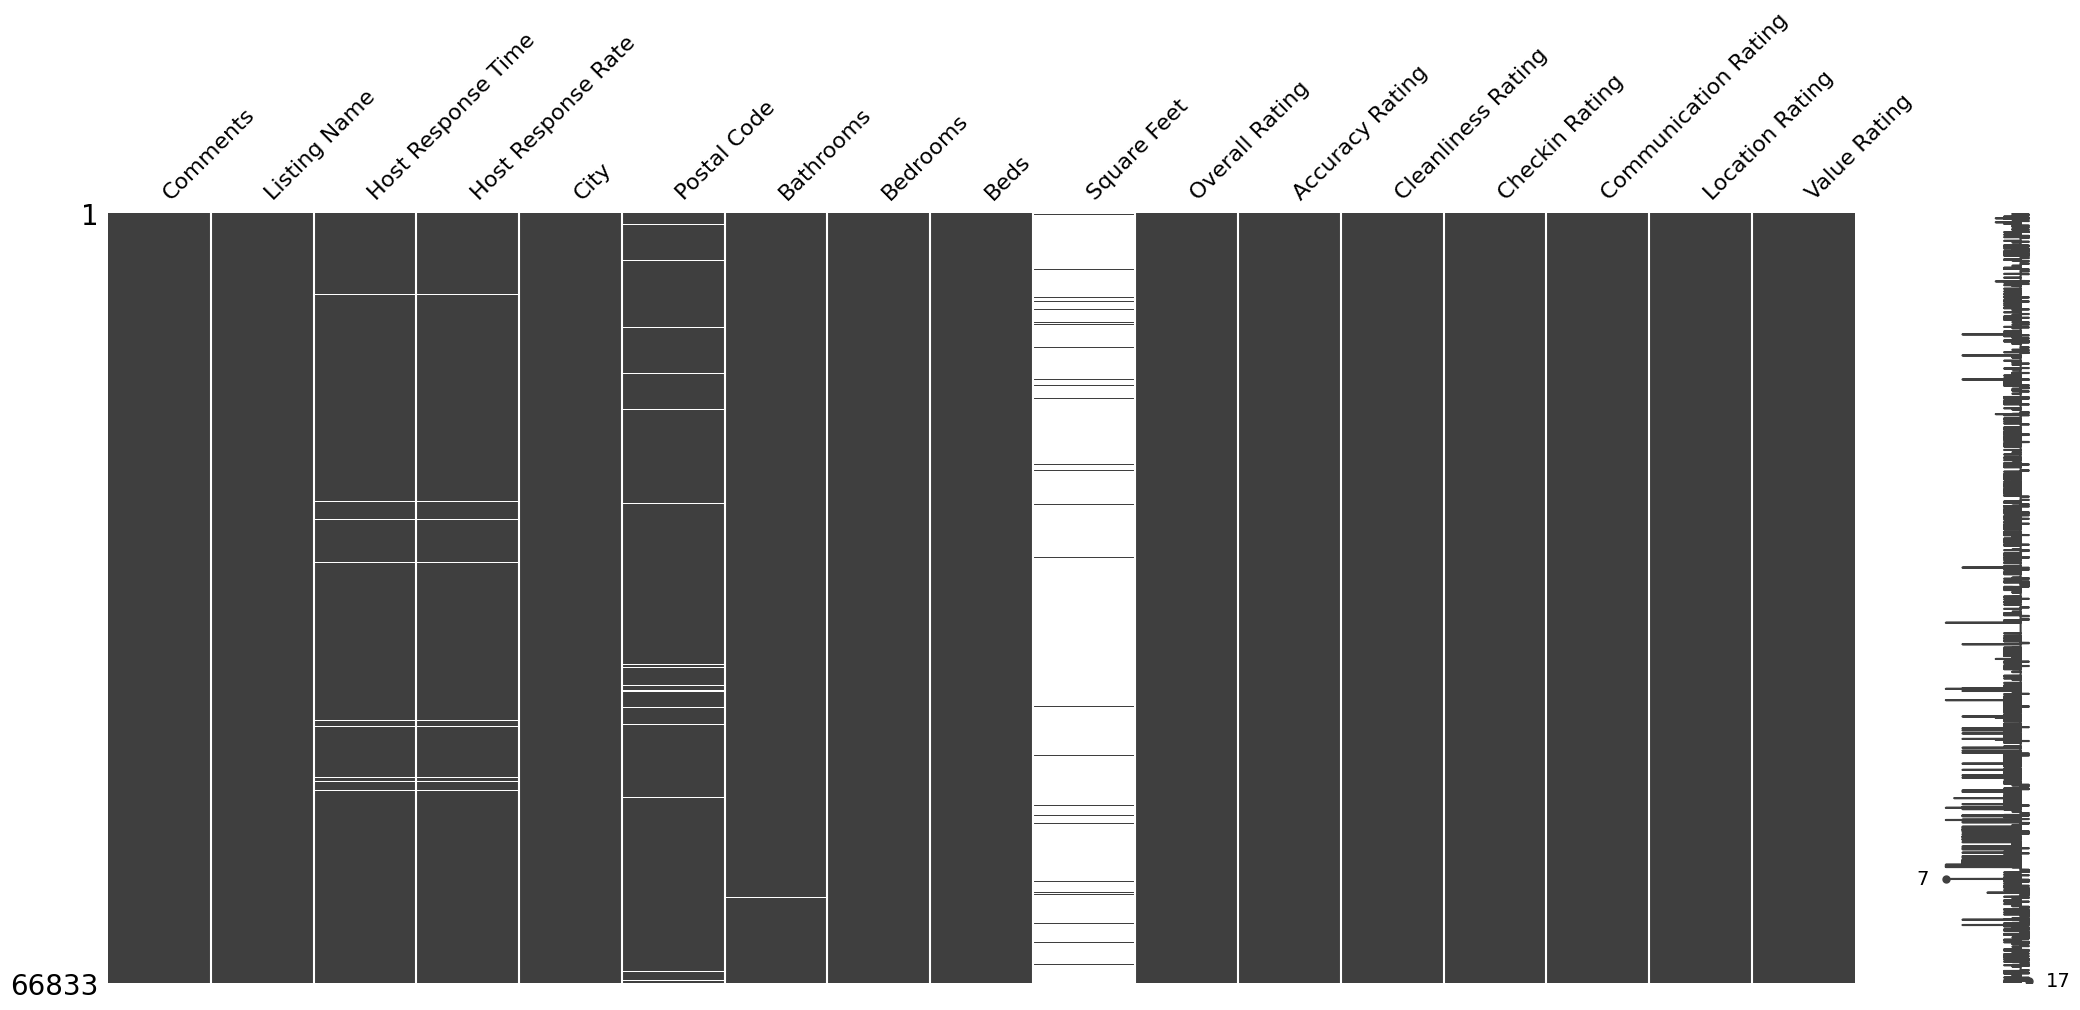

In [6]:
#show missing values
#!pip install missingno
import missingno as msno

### plot the missingness (nullity) matrix
missingdata_df = df.columns[df.isnull().any()].tolist()
msno.matrix(df[missingdata_df])
